In [22]:
#might want to use this for classification metrics visualization
#conda install -c districtdatalabs yellowbrick
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport
import sklearn
sklearn.set_config(transform_output="pandas")
# import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
labeller  =  preprocessing.LabelEncoder()

In [23]:
order_items = pd.read_csv('./dataset/olist_order_items_dataset.csv')
customers = pd.read_csv('./dataset/olist_customers_dataset.csv')
sellers = pd.read_csv('./dataset/olist_sellers_dataset.csv')
products = pd.read_csv('./dataset/olist_products_dataset.csv')
orders = pd.read_csv('./dataset/olist_orders_dataset.csv')
reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
orders[['order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date']] = orders[['order_purchase_timestamp',
                                                    'order_approved_at',
                                                    'order_delivered_carrier_date',
                                                    'order_delivered_customer_date',
                                                    'order_estimated_delivery_date']].apply(pd.to_datetime) 
reviews[['review_creation_date',
        'review_answer_timestamp']] = reviews[['review_creation_date',
                                                    'review_answer_timestamp']].apply(pd.to_datetime) 
order_items[['shipping_limit_date']] = order_items[['shipping_limit_date']].apply(pd.to_datetime)
# order_items.info(),orders.info()
# order_items.head()
# customers.head(),order_items.head(),orders.head(),customers[customers['customer_id'] == "9ef432eb6251297304e76186b10a928d"], customers[customers['customer_unique_id'] == "9ef432eb6251297304e76186b10a928d"]
# ProfileReport(order_items,title="order of items").to_widgets()


merged = pd.merge(orders,order_items)
merged = merged.merge(customers)
merged = merged.merge(sellers)
merged = merged.merge(products)
merged = merged.merge(reviews)

merged['product_photos_qty']=merged['product_photos_qty'].fillna(0)
merged[merged['product_photos_qty'].isna()][['customer_id','product_photos_qty']]

# merged[['seller_city','seller_state','customer_city','customer_state']] = merged[['seller_city','seller_state','customer_city','customer_state']].astype('category') 
# merged[['seller_city','seller_state','customer_city','customer_state']].info()

merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))
merged['review_score'] = labeller.fit_transform(merged['review_score'].astype('str'))
merged[['seller_city','seller_state','customer_city','customer_state']].info()


merged['time_to_get'] =   merged.order_delivered_customer_date - merged['order_purchase_timestamp']
merged['time_to_get'] = merged['time_to_get'].dt.seconds/60
merged['time_to_get']  = merged['time_to_get']


merged['time_to_get'] = merged['time_to_get'].replace(np.nan, 0)
merged.time_to_get.isna().sum()

# merged.info()
# ProfileReport(merged,title="order of items").to_widgets()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112372 entries, 0 to 112371
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   seller_city     112372 non-null  int64
 1   seller_state    112372 non-null  int64
 2   customer_city   112372 non-null  int64
 3   customer_state  112372 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


0

In [24]:
# merged.isna().sum()

In [25]:
# merged['product_photos_qty'].fillna(0)



In [26]:
# merged.review_score.value_counts().plot(kind='bar')

# merged.pivot_table(index='review_score',aggfunc='count')

In [27]:

# Load the data and define features and target variable
# merged = pd.read_csv('order_data.csv')
X = merged[['price','freight_value','seller_city','seller_state','customer_city','customer_state','time_to_get']]
# merged['review_score_transformed'] = merged['review_score']-1
y = merged['review_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


# # Train the SVM model
# svm_model = SVC()
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
xgb_pred = xgb_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

# svm_pred = svm_model.predict(X_test)

# # Classification report for XGBoost model
xgb_report = classification_report(y_test, xgb_pred)
print("XGBoost Classification Report:")
print(xgb_report)

# # Classification report for Random Forest model
rf_report = classification_report(y_test, rf_pred)
print("Random Forest Classification Report:")
print(rf_report)




# # Classification report for SVM model
# svm_report = classification_report(y_test, svm_pred)
# print("SVM Classification Report:")
# print(svm_report)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.15      0.25      2848
           1       0.76      0.02      0.04       726
           2       0.75      0.02      0.03      1886
           3       0.55      0.01      0.03      4222
           4       0.59      0.99      0.74     12793

    accuracy                           0.59     22475
   macro avg       0.66      0.24      0.22     22475
weighted avg       0.61      0.59      0.46     22475

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.38      0.49      2848
           1       0.74      0.22      0.34       726
           2       0.62      0.17      0.26      1886
           3       0.50      0.18      0.26      4222
           4       0.63      0.93      0.75     12793

    accuracy                           0.63     22475
   macro avg       0.64      0.37      0.42     22475
weighted 

In [28]:
# Train the Random Logistic Regression
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200000)
logreg_model.fit(X_train,y_train)

logr_pred = logreg_model.predict(X_test)

logr_report = classification_report(y_test, logr_pred,zero_division=0)
print("Logistic Regression Classification Report:")
print(logr_report)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2848
           1       0.00      0.00      0.00       726
           2       0.00      0.00      0.00      1886
           3       0.00      0.00      0.00      4222
           4       0.57      1.00      0.73     12793

    accuracy                           0.57     22475
   macro avg       0.11      0.20      0.15     22475
weighted avg       0.32      0.57      0.41     22475



In [34]:
# reports = [logr_report,xgb_report,rf_report]
# reports_name = ['mlr','xgb','rforest']


# import matplotlib.pyplot as plt
# # from sklearn.metrics import classification_report
# accuracy_list = []
# model_labels = []

# # Iterate over the classification reports
# for i, report in enumerate(reports):
#     # Split the report lines and extract the accuracy value
#     # print(lines)
#     # print(report)
#     lines = report.split('\n')
#     accuracy_line = lines[8]
#     accuracy = float(accuracy_line.split()[-2])

#     # Add accuracy to the list
#     accuracy_list.append(accuracy)
#     model_labels.append(f"{reports_name[i]} Accuracy")

# # Plot the accuracy values
# plt.figure(figsize=(10, 6))
# x = range(len(model_labels))
# plt.bar(x, accuracy_list)
# plt.xticks(x, model_labels)
# # plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Accuracy of Classification Models')
# plt.show()




<Axes: title={'center': 'logreg'}, xlabel='Predicted label', ylabel='True label'>

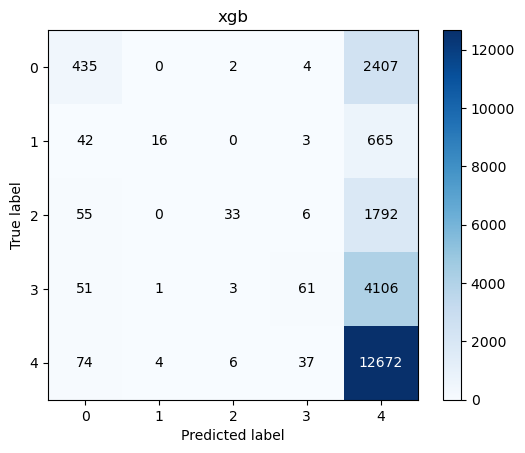

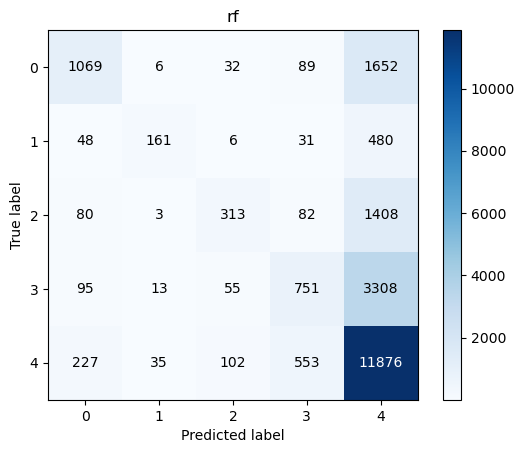

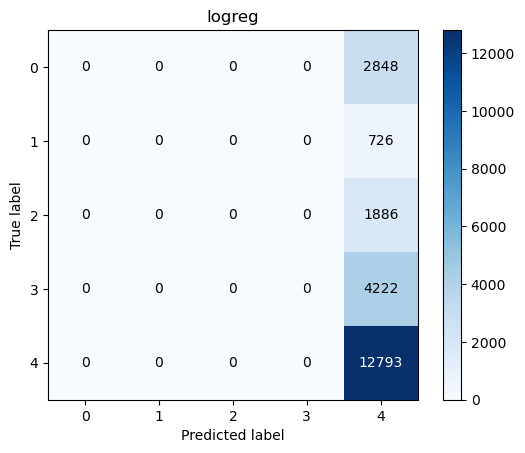

In [33]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, xgb_pred, normalize=False, title = 'xgb')
skplt.metrics.plot_confusion_matrix(y_test, rf_pred, normalize=False, title = 'rf' )
skplt.metrics.plot_confusion_matrix(y_test, logr_pred, normalize=False, title = 'logreg')